# Generate Image of Masked Faces
The face mask data set from [this source](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset?select=Face+Mask+Dataset) does not really have many examples of masked people. They contain around 700 masked images and then augmented to produce 5000 masked image. So this method to generated masked people from unmasked people was inspired from the paper [MaskedFace-Net – A dataset of correctly/incorrectly masked face images in the context of COVID-19](https://www.sciencedirect.com/science/article/pii/S2352648320300362). They link to a GitHub page with a Labled Dataset (with 4 classes), but since my objective is to find the effictiveness of **Multiple Pooling**, I wanted a simple dataset for binary classification. So generating the dataset gave me the flexibility to satisfy my requirements.

This Notebook is just for demonstration, the polished code is in `utils/generate_masked_faces.py` file.

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import mediapipe as mp

# Loading Data
The mask is first converted to a .png image with transparent background. Then 6 landmarks are annotated onto the image using external software. These 6 landmarks are later used to project the mask onto 6 landmarks on the face. The annotations are stored in an external `.csv` file, we drop all the columns except the `(x,y)` coordinates of the annotations. We can see the annotations on the image below.

In [20]:
face_img = cv2.imread("./assets/00059.png")
face_img_copy = face_img.copy()
mask_img = cv2.imread("./assets/mask_blue.png", -1) # -1 to get the alpha(transperancy) channel
mask_img_copy = mask_img.copy()
mask_annotation = np.genfromtxt('./assets/mask_blue_6.csv', delimiter=',', dtype=int)
mask_annotation = np.delete(mask_annotation, [0,3,4,5], axis=1) #get the (x,y) of annotations

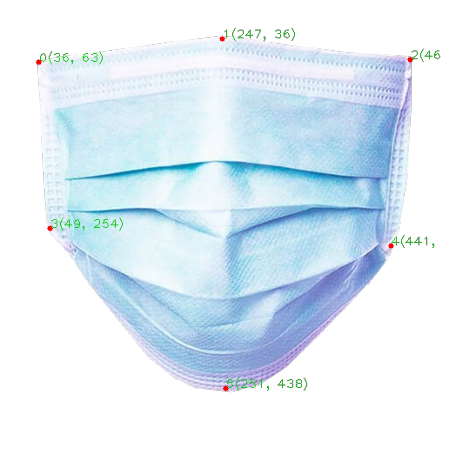

In [16]:
m_height, m_width = face_img.shape[:2]
for idx, xy in enumerate(mask_annotation):
    cv2.circle(mask_img_copy, (xy[0], xy[1]), 3, (0,0,255,255), -1) # img, location, size of circle, color (4 channels since RGBA), -1 to fill with color
    cv2.putText(mask_img_copy, str(idx) + f"{xy[0], xy[1]}", (xy[0],xy[1]), 1, 1, (0,200,0,255)) # img, text, locaiton, font, size, color

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(cv2.cvtColor(mask_img_copy, cv2.COLOR_BGR2RGBA));

# Get the Face Landmarks
We then use Google's `mediapipe` library to find the landmarks (FaceMesh) on the face. This landmark detection model returns 468 landmarks, but using just 6 of those landmarks to fit the mask gives a reasonable output. We select the 6 landmarks that corresponds to the 6 points annotated in the mask (these 6 indices does not change from image to image, so they can be hardcoded). We then find the `(x,y)` coordinates of these 6 landmark indices and store them in an numpy array. 

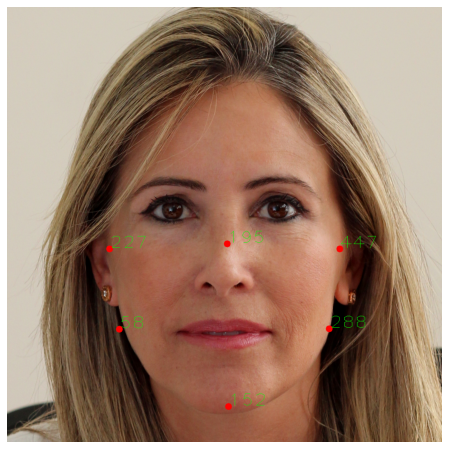

In [17]:
face_mesh_model = mp.solutions.face_mesh.FaceMesh()
face_landmarks = face_mesh_model.process(face_img)

f_height, f_width = face_img.shape[:2]

# 16 handpicked face landmark indices (out of 468) corresponding to the points in the mask.
# landmarks_for_mask = [227, 447, 197, 399, 174, 132, 361, 288, 58, 172, 397, 137, 365, 149, 378, 152] 
landmarks_for_mask = [227, 195, 447, 58, 288, 152] # 6 works much better

if face_landmarks.multi_face_landmarks is None:
    print("No faces detected")
else:
    for face in face_landmarks.multi_face_landmarks:
        face_annotation = []
        for i in landmarks_for_mask:
            landmark = face.landmark[i]
            xy = int(landmark.x * f_width), int(landmark.y * f_height)
            face_annotation.append(np.array(xy))

            # draw the points on the face
            cv2.circle(face_img_copy, xy, 8, (0,0,255), -1) # img, location, size of circle, color, fill with color
            cv2.putText(face_img_copy, str(i), xy, 1, 3, (0,255,0)) # img, text, locaiton, font, size, color
        
        face_annotation = np.array(face_annotation)
            
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(cv2.cvtColor(face_img_copy, cv2.COLOR_BGR2RGB));  

# Apply Mask to Face
Now that we have the 6 `(x,y)` coordinates of the mask and the face, we can project the mask onto the image. We first calculate a homography matrix which gives directions on how to "stretch or squish" the mask such that it fits the face. We also made sure the order of the coordniates of both mask and face match, else you can get some interesting results!

Using the homography matrix, the mask can be warped so that it will be proportional to the face. Then we take the alpha channel of the `warped` image and normalize and transform it into 3 channels (this is used to apply the mask to the face). Now we strip the `warped` image of the alpha channel. Then `warped_multiplied` gives the warped mask with the background transpraent and `image_multiplied` gives the face with the location of the mask transparent (use `.imshow` to view them). Then we can add them both to get the final image.

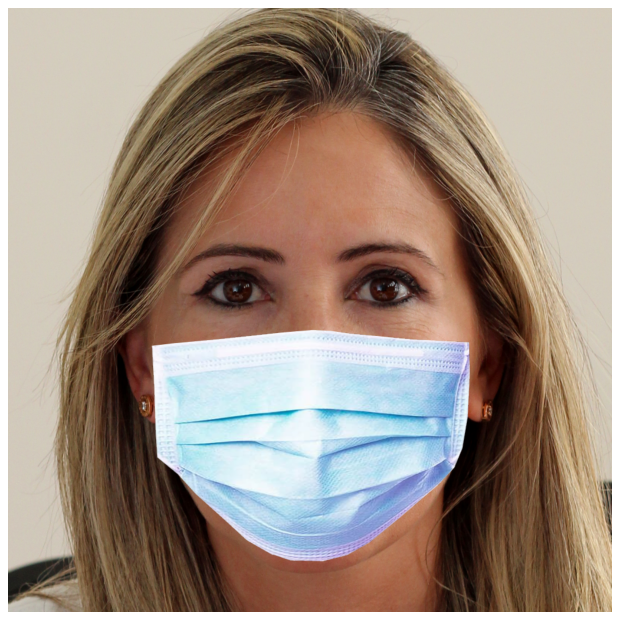

In [18]:
hom = cv2.findHomography(mask_annotation, face_annotation)[0]
warped = cv2.warpPerspective(mask_img, hom, (f_width, f_height), None, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

# Get alpha channel (index 3)
alpha_channel = warped[:,:, -1]
# Copy and convert the mask to a float and give it 3 channels
alpha_channel_scaled = alpha_channel.copy() / 255.0
alpha_channel_scaled = np.dstack([alpha_channel_scaled] * 3)    
# Remove the alpha channel from the warped image
warped = cv2.cvtColor(warped, cv2.COLOR_BGRA2BGR)

# Make the bg of mask tranparent
warped_multiplied = cv2.multiply(alpha_channel_scaled, warped.astype("float"))
# Make the location of the mask on face transparent
image_multiplied = cv2.multiply(face_img.astype(float), 1.0 - alpha_channel_scaled)
# Add to get the final image
output = cv2.add(warped_multiplied, image_multiplied).astype("uint8")

plt.figure(figsize=(10, 10), dpi=80)
plt.axis('off')
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB));